In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Predicting_MLB_outcomes/

/content/drive/MyDrive/Predicting_MLB_outcomes


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
import lightgbm
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
file = './data/Retrosheet_2010_2019/2010_to_2019_seasons.csv'
game_df = pd.read_csv(file)

game_col_del = '''VisitorGDP,VisitorCI,HomeGDP,HomeCI, DoubleHeader, DayOfWeek, VisitingTeamLeague, HomeTeamLeague, DayNight, CompletionInfo,ForfeitInfo, ProtestInfo, Duration, VisitorLineScore, HomeLineScore, UmpireHID, UmpireHName, Umpire1BID, Umpire1BName, Umpire2BID,Umpire2BName, Umpire3BID, Umpire3BName, UmpireLFID, UmpireLFName, UmpireRFID,UmpireRFName, VisitorManagerID, VisitorManagerName, HomeManagerID, HomeManagerName,WinningPitcherID, WinningPitcherName, LosingPitcherID, LosingPitcherNAme,SavingPitcherID, SavingPitcherName, GameWinningRBIID, GameWinningRBIName, VisitorBatting1Position, VisitorBatting2Position, VisitorBatting3Position,VisitorBatting4Position, VisitorBatting5Position, VisitorBatting6Position,VisitorBatting7Position, VisitorBatting8Position, VisitorBatting9Position,HomeBatting1Position, HomeBatting2Position, HomeBatting3Position,HomeBatting4Position, HomeBatting5Position, HomeBatting6Position,HomeBatting7Position, HomeBatting8Position, HomeBatting9Position,AdditionalInfo, AcquisitionInfo'''
game_col_del = game_col_del.replace(" ", "")
game_col_del = game_col_del.split(",")

game_df.drop(game_col_del,axis=1,inplace=True)


col_del = ['VisitorBatting1PlayerID', 'VisitorBatting1Name', 'VisitorBatting2PlayerID', 'VisitorBatting2Name', 'VisitorBatting3PlayerID', 'VisitorBatting3Name', 'VisitorBatting4PlayerID', 'VisitorBatting4Name', 'VisitorBatting5PlayerID', 'VisitorBatting5Name', 'VisitorBatting6PlayerID', 'VisitorBatting6Name', 'VisitorBatting7PlayerID', 'VisitorBatting7Name', 'VisitorBatting8PlayerID', 'VisitorBatting8Name', 'VisitorBatting9PlayerID', 'VisitorBatting9Name', 'HomeBatting1PlayerID', 'HomeBatting1Name', 'HomeBatting2PlayerID', 'HomeBatting2Name', 'HomeBatting3PlayerID', 'HomeBatting3Name', 'HomeBatting4PlayerID', 'HomeBatting4Name', 'HomeBatting5PlayerID', 'HomeBatting5Name', 'HomeBatting6PlayerID', 'HomeBatting6Name', 'HomeBatting7PlayerID', 'HomeBatting7Name', 'HomeBatting8PlayerID', 'HomeBatting8Name', 'HomeBatting9PlayerID', 'HomeBatting9Name']
game_df.drop(col_del,axis=1,inplace=True)
game_df = game_df.rename(columns={"VisitingTeam":"VisitorTeam","VisitingTeamGameNumber":"VisitorTeamGameNumber"})

In [5]:
away_inning = game_df['LengthInOuts']//2
home_inning = game_df['LengthInOuts']- away_inning

game_df['VisitorOffInn'] = away_inning
game_df['VisitorDifInn'] = home_inning
game_df['HomeOffInn'] = home_inning
game_df['HomeDifInn'] = away_inning


game_df['Date'] = pd.to_datetime(game_df['Date'].astype(str), format='%Y%m%d')
game_df['current_year'] = game_df['Date'].dt.year
game_df['Home_team_won?'] = game_df['HomeRunsScore'] > game_df['VisitorRunsScored']
game_df['Visitor_team_won?'] = game_df['HomeRunsScore'] < game_df['VisitorRunsScored']

In [6]:
# Merging park factors
file = './park_factors.csv'
parkfactor_df = pd.read_csv(file, encoding='cp949')
game_df = pd.merge(game_df, parkfactor_df, on="HomeTeam")

In [7]:
# Attendence
my_attendence={'BOS':37755, 'LAA':45517, 'CWS':40615, 'KC':37903, 'OAK':56782, 'TEX':40300, 'ARI':48686, 'ATL':41084, 'CIN':42319,
       'HOU':41168, 'MIL':41900, 'NYM':41922, 'PIT':38747, 'WAS':41339, 'TB':42735, 'BAL':44970, 'DET':41083, 'COL':50144,
       'MIA':37442, 'SF':41265, 'CLE':34830, 'MIN':38544, 'SEA':47929, 'TOR':49282, 'CHC':41649, 'PHI':42792, 'SD':40209, 'STL':45494,
       'NYY':54251, 'LAD':56000}

for key, value in my_attendence.items():
  game_df.loc[game_df['HomeTeam']==key,'Attendence']=game_df.loc[game_df['HomeTeam']==key,'Attendence']/value

trend=1 #몇일 롤링
game_df[f'{trend}d_home_attendance'] = game_df.groupby(['current_year', 'HomeTeam'])['Attendence'].transform(lambda x: round(x.rolling(trend).mean().shift(periods=1, axis=0), 3))

In [8]:
bat_stat = [ 'TeamGameNumber','Team','AB','H','D','T','HR','RBI','SH','SF',
'HBP','BB','IBB','K','SB','CS','LOB','Pitchers',
'ER','TER','WP','Balks','PO','A','E','Passed','DB','TP','OffInn','DifInn','_team_won?']
pit_stat = ['H', 'D', 'T', 'HR', 'RBI', 'SH', 'SF', 'HBP', 'BB', 'IBB', 'K', 'LOB', 'ER','DB','AB']

In [9]:
select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}

In [10]:
# rename1, rename2

In [11]:
## Home 시각 
select_stat = ['Date']
select_stat += ['Home'+i for i in bat_stat]+['Visitor'+i for i in pit_stat]
rename1 = {'Visitor'+i:'Pit'+i for i in pit_stat}
rename2 = {'Home'+i:i for i in bat_stat}
Home = game_df.copy()
Home = Home[select_stat].rename(columns=rename1)
Home = Home.rename(columns=rename2)
# away 시각
select_stat = ['Date']
select_stat += ['Visitor'+i for i in bat_stat]+['Home'+i for i in pit_stat]
rename1 = {'Home'+i:'Pit'+i for i in pit_stat}
rename2 = {'Visitor'+i:i for i in bat_stat}
Visitor = game_df.copy()
Visitor = Visitor[select_stat].rename(columns=rename1)
Visitor = Visitor.rename(columns=rename2)

In [12]:
sep_team = pd.concat([Home,Visitor])
sep_team = sep_team.rename(columns={'PitDB':'DP'})

In [13]:
# 누적 값
col = ['AB', 'H', 'D', 'T', 'HR', 'RBI','DP',
       'SF', 'BB', 'K', 'SB', 'CS', 'LOB', 'Pitchers', 'ER', 'TER', 'WP','PitAB',
       'Balks', 'PO', 'A', 'E', 'Passed', 'DB', 'TP', 'OffInn', 'DifInn',
       'PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF',
       'PitBB', 'PitK', 'PitLOB', 'PitER']

In [14]:
a = sep_team.copy()
sep_team['year']= sep_team.Date.dt.year
sep_team[col] = sep_team.groupby(['year','Team'])[col].transform(lambda x: x.expanding(1).sum())
sep_team[col] = sep_team[col].subtract(a[col])
sep_team = sep_team[sep_team['TeamGameNumber']>=10]

In [16]:
select_feature = ['Date', 'TeamGameNumber', 'Team','_team_won?']
# feature selection
select_feature += ['AB', 'H', 'D', 'T', 'HR', 'RBI','BB', 'K','DP', 'HBP','IBB','SF','SH',#bat stat
                    'ER','OffInn','DifInn' # game info
                    ,'PitAB','PitH', 'PitD', 'PitT', 'PitHR', 'PitRBI', 'PitSF', 'PitBB',"PitIBB","PitHBP" ,'PitK','PitLOB', 'PitER'
                    ]


In [17]:
sep = sep_team[select_feature] 

In [18]:
# H, OBP, SLG, ISO, Babip, RC, wOBA X, K, BB, RBI, K/B, HR   
# 타자 가공
sep['RC'] = ((sep['H']+sep['BB']+sep['HBP']-sep['DP'])
        *(sep['H']+2*sep['D']+3*sep['T']+4*sep['HR']+0.52*(sep['SF']+sep['SH'])+0.26*(sep['BB']+sep['HBP']-sep['IBB']))
        )/(sep['AB']*sep['AB']) #득점 생산


#사구,사사구, 고의사구 통합
sep['BB'] += sep['HBP']+sep['IBB']
sep['PitBB'] += sep['PitHBP']+sep['PitIBB']
#del sep['HBP'],sep['IBB'],sep['PitHBP'],sep['PitIBB']
# 희생번트, 희생플라이 통합
sep['PitSF'] += sep_team['PitSH']
sep['SF'] += sep['SH']
#del sep['SH'],sep['PitSH']

sep['K/B'] = sep['K']/(sep['BB']+0.5)
sep['PA'] = sep['AB'] - sep['BB'] - sep['SF'] # 타수
sep['Babip'] = (sep['H']+sep['D']+sep['T']) / (sep['PA']-sep['K']-sep['HR']-sep['SF']) # 인플레이 타구
sep['SLG'] = (sep['H']+2*sep['D']+3*sep['T']+4*sep['HR'])/sep['PA'] # 장타율
sep['H'] = sep['H']/sep['PA'] # 안타율
sep['D'] = sep['D']/sep['PA'] # 안타율
sep['T'] = sep['T']/sep['PA'] # 안타율
sep['HR'] = sep['HR']/sep['PA'] # 안타율
sep['BB'] = sep['BB']/sep['PA'] # 볼넷
sep['RBI'] = sep['RBI']/sep['TeamGameNumber'] # 득점

sep['OBP'] = (sep['H']+sep['BB']) #출루율
sep['OPS'] = sep['SLG']+sep['OBP'] #OPS
sep['GPA'] = (1.8*sep['OBP']+sep['SLG'])/4 #GPA(Gross Production Average) - park factor를 적용해야함
sep['ISO'] = sep['SLG'] - sep['H']


In [19]:
# 투수 가공
# PitH, PitOBP, PitSLG, PitOPS, PitHR, EAR, PitB, PitK, PitK/B, WHIP, kwERA
sep['ERA'] = sep['PitER']/sep['DifInn']
sep['TotalH'] = sep['PitH']+sep['PitD']+sep['PitT']+sep['PitHR']
sep['TotalBB'] = sep['PitBB']+sep['PitHBP']
sep['PitPA'] = sep['PitAB'] - sep['TotalBB'] - sep['PitSF']
sep['kwERA'] = (5.40-12*(sep['PitK'] - sep['TotalBB']))/sep['PitPA']
sep['WHIP'] = (sep['TotalH']+sep['TotalBB'])/sep['DifInn']
sep['PitK'] = sep['PitK']/sep['DifInn']
sep['PitB'] = sep['TotalBB']/sep['DifInn']
sep['PitK/B'] = sep['PitK']/(sep['PitB']+0.5)


sep['PitSLG'] = (sep['PitH']+2*sep['PitD']+3*sep['PitT']+4*sep['PitHR'])/sep['PitPA'] # 피장타율
sep['PitH'] = sep['PitH']/sep['PitPA'] # 피안타율
sep['PitOBP'] = (sep['TotalH']+sep['TotalBB']) / sep['PitAB'] #피출루율
sep['PitOPS'] = sep['PitSLG']+sep['PitOBP'] #피OPS
sep['PitHR'] /= sep['PitPA']

In [20]:

#temp = sep[['Date', 'TeamGameNumber', 'Team', '_team_won?','GPA', 'OPS','OBP','H','SLG','Babip','RC']]
temp = sep
game_log = game_df[['Date','VisitorTeam','HomeTeam','VisitorTeamGameNumber','HomeTeamGameNumber', 'ParkFactors', 'Attendence']]

game_log = game_log[game_log.VisitorTeamGameNumber>=10]
game_log = game_log[game_log.HomeTeamGameNumber>=10]

game_log = pd.merge(game_log,temp,left_on = ['Date','VisitorTeam'], right_on = ['Date','Team'],how='left')
game_log = pd.merge(game_log,temp,left_on = ['Date','HomeTeam'], right_on = ['Date','Team'],how='left')

game_log['year'] = game_log.Date.dt.year
train = game_log[game_log.year!=2019]
test = game_log[game_log.year==2019]

In [21]:
# 'H','OBP','SLG','ISO','Babip','RC','K','BB','RBI','K/B','HR','PitH','PitOBP','PitSLG','PitOPS','PitHR','EAR','PitB','PitK','PitK/B','WHIP'

In [22]:
# game_log[game_log['HomeTeam']=='SEA']['Date']

In [23]:
y_cols = ['_team_won?_x']
select = ['H','OBP','SLG','ISO','Babip','RC','K','BB','RBI','K/B','HR','PitH','PitOBP','PitSLG','PitOPS','PitHR','ERA','PitB','PitK','PitK/B','WHIP']
# select = ['H', 'D', 'T', 'HR', 'RBI', 'BB']
x_cols = [i+'_x' for i in select]
x_cols += [i+'_y' for i in select]
x_cols += ['ParkFactors', 'Attendence']
train = train.dropna()
test = test.dropna()


In [24]:
y_train = train[y_cols]*1
y_test = test[y_cols]*1

X_train = train[x_cols]
X_test = test[x_cols]
x_ = [i+'_x' for i in select]
y_ = [i+'_y' for i in select]
'''
diff
X_train = X_train[x_].to_numpy() - X_train[y_].to_numpy()
X_test = X_test[x_].to_numpy() - X_test[y_].to_numpy()
'''

'''
div
X_train = np.log(X_train[x_].to_numpy()) - np.log(X_train[y_].to_numpy()+1e-6)
X_test = np.log(X_test[x_].to_numpy()) - np.log(X_test[y_].to_numpy()+1e-6)
'''

'\ndiv\nX_train = np.log(X_train[x_].to_numpy()) - np.log(X_train[y_].to_numpy()+1e-6)\nX_test = np.log(X_test[x_].to_numpy()) - np.log(X_test[y_].to_numpy()+1e-6)\n'

In [25]:
'''
    Z-score normalization
'''
scaler = StandardScaler()
scaler.fit(train[x_cols])
X_train = scaler.transform(train[x_cols])
X_test = scaler.transform(test[x_cols])

In [26]:
X_train = train[x_cols]
y_train = train[y_cols]*1

X_test = test[x_cols]
y_test = test[y_cols]*1

model = sm.Logit(y_train,X_train)
results = model.fit()
print(results.summary())

y_hat = results.predict( X_train)
y_hat = list(map(round,y_hat))
print('Train accuracy = ', accuracy_score(y_train, y_hat))

y_hat = results.predict( X_test)
y_hat = list(map(round,y_hat))
print('Test accuracy = ', accuracy_score(y_test, y_hat))

Optimization terminated successfully.
         Current function value: 0.680750
         Iterations 16
                           Logit Regression Results                           
Dep. Variable:           _team_won?_x   No. Observations:                13742
Model:                          Logit   Df Residuals:                    13704
Method:                           MLE   Df Model:                           37
Date:                Fri, 06 May 2022   Pseudo R-squ.:                 0.01463
Time:                        05:16:10   Log-Likelihood:                -9354.9
converged:                       True   LL-Null:                       -9493.7
Covariance Type:            nonrobust   LLR p-value:                 1.166e-38
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
H_x             1.9609        nan        nan        nan         nan         nan
OBP_x           2.8460   

In [27]:
num_thread = 8
# num of cpu 

In [28]:
param ={'num_leaves':[4,6,8,10,20],'max_depth':[-1,3,6,9,12,15]}
lgb =LGBMClassifier()
lgb_clf = GridSearchCV(lgb,param,scoring='accuracy',n_jobs=num_thread)
lgb_results = lgb_clf.fit(X_train, y_train.values.ravel(), eval_metric=['logloss'],eval_set=[(X_test, y_test.values.ravel())],callbacks=[lightgbm.early_stopping(10, verbose=0)])

train_score = lgb_results.score(X_train, y_train)
test_score = lgb_results.score(X_test, y_test)
print(lgb_results.best_params_)
print(test_score)

KeyboardInterrupt: ignored

In [ ]:
rf_param ={'min_samples_split':[4,6,8,10,20],'max_depth':[-1,3,6,9,12,15]}
rf =RandomForestClassifier()
rf_clf = GridSearchCV(rf,rf_param,scoring='accuracy',n_jobs=num_thread)
rf_results = rf_clf.fit(X_train,  y_train.values.ravel())


train_score = rf_results.score(X_train, y_train)
test_score = rf_results.score(X_test, y_test)
print(rf_results.best_params_)
print(test_score)

In [ ]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0] 
svm_param  = [{'C': param_range, 'kernel': ['linear']}, {'C': param_range, 'gamma': param_range, 'kernel': ['rbf']}]
svm_model =svm.SVC()
svm_clf = GridSearchCV(estimator=svm_model,param_grid=svm_param,scoring='accuracy',n_jobs=num_thread,verbose=0)
svm_results = svm_clf.fit(X_train, y_train.values.ravel())

train_score = svm_results.score(X_train, y_train)
test_score = svm_results.score(X_test, y_test)
print(svm_results.best_params_)
print(test_score)

In [29]:
!pip install pytorch-tabnet

In [30]:
col_tmp = X_test.columns
X_train=X_train.values
y_train=y_train.values
X_test=X_test.values
y_test=y_test.values
y_test = np.squeeze(y_test)
y_train = np.squeeze(y_train)

In [31]:
import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=1e-2),
                       scheduler_params={"step_size":50,
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # "sparsemax", entmax
                      )

max_epochs = 200

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train)],
    eval_name=['train'],
    eval_metric=['auc','accuracy'],
    max_epochs=max_epochs , patience=10,
    batch_size=128, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=True,
)


Device used : cuda
epoch 0  | loss: 0.72808 | train_auc: 0.50925 | train_accuracy: 0.47591 |  0:00:07s
epoch 1  | loss: 0.69498 | train_auc: 0.53094 | train_accuracy: 0.48494 |  0:00:17s
epoch 2  | loss: 0.69364 | train_auc: 0.5356  | train_accuracy: 0.52234 |  0:00:27s
epoch 3  | loss: 0.69126 | train_auc: 0.54302 | train_accuracy: 0.52423 |  0:00:34s
epoch 4  | loss: 0.69183 | train_auc: 0.55138 | train_accuracy: 0.52591 |  0:00:39s
epoch 5  | loss: 0.69105 | train_auc: 0.54725 | train_accuracy: 0.53078 |  0:00:43s
epoch 6  | loss: 0.69071 | train_auc: 0.55986 | train_accuracy: 0.53973 |  0:00:48s
epoch 7  | loss: 0.68875 | train_auc: 0.56354 | train_accuracy: 0.54905 |  0:00:52s
epoch 8  | loss: 0.68994 | train_auc: 0.5575  | train_accuracy: 0.54235 |  0:00:57s
epoch 9  | loss: 0.68843 | train_auc: 0.56155 | train_accuracy: 0.55261 |  0:01:01s
epoch 10 | loss: 0.69039 | train_auc: 0.56119 | train_accuracy: 0.539   |  0:01:06s
epoch 11 | loss: 0.68932 | train_auc: 0.56786 | train_acc

In [32]:
# from sklearn.metrics import roc_auc_score
# preds = clf.predict_proba(X_test)
# test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)
# test_auc

In [33]:
# determine best accuracy for validation set
preds_valid = clf.predict(X_test)
test_acc = accuracy_score(preds_valid, y_test)

print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")

BEST ACCURACY SCORE ON TEST SET : 0.5946649316851008


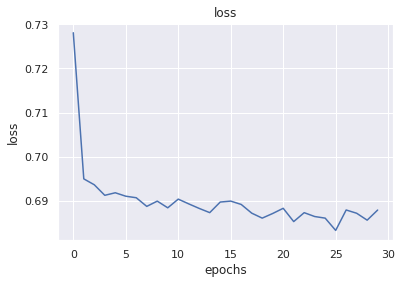

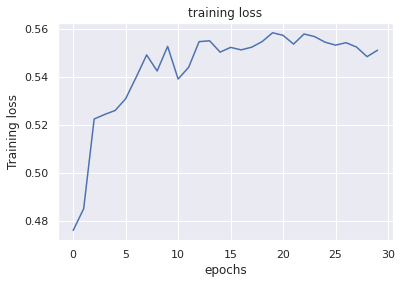

In [34]:
# plot losses
plt.plot(clf.history['loss'])
plt.title('loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

# plot accuracy
plt.plot(clf.history['train_accuracy'])
# plt.plot(clf.history['test_accuracy'])
plt.title('training loss')
plt.xlabel('epochs')
plt.ylabel('Training loss')
plt.show()

In [35]:
clf.feature_importances_

array([3.36386940e-05, 2.04632598e-06, 0.00000000e+00, 0.00000000e+00,
       1.57447142e-02, 1.71350304e-02, 2.14982341e-05, 0.00000000e+00,
       5.78758990e-05, 7.07900868e-02, 3.70979704e-02, 2.67361256e-03,
       9.17677142e-02, 5.02493580e-04, 2.59556869e-02, 0.00000000e+00,
       3.51370619e-02, 6.55065251e-04, 5.76799379e-04, 1.06445085e-01,
       1.88875471e-01, 3.79740402e-02, 1.25998363e-03, 5.37028328e-05,
       1.04740756e-05, 2.19358619e-03, 8.64606911e-02, 3.94514341e-05,
       2.04577461e-03, 1.26553829e-02, 6.04280006e-04, 2.35759011e-02,
       1.55143127e-01, 2.30448494e-05, 2.67129989e-04, 0.00000000e+00,
       6.03096260e-03, 1.24979601e-03, 1.02126444e-02, 1.88326777e-02,
       4.48460790e-02, 1.15778331e-03, 4.06299851e-05, 1.85100552e-03])

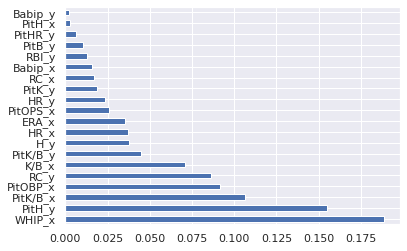

In [36]:
# find and plot feature importance
y_pred = clf.predict(X_test)
clf.feature_importances_
feat_importances = pd.Series(clf.feature_importances_, index=col_tmp)
feat_importances.nlargest(20).plot(kind='barh')

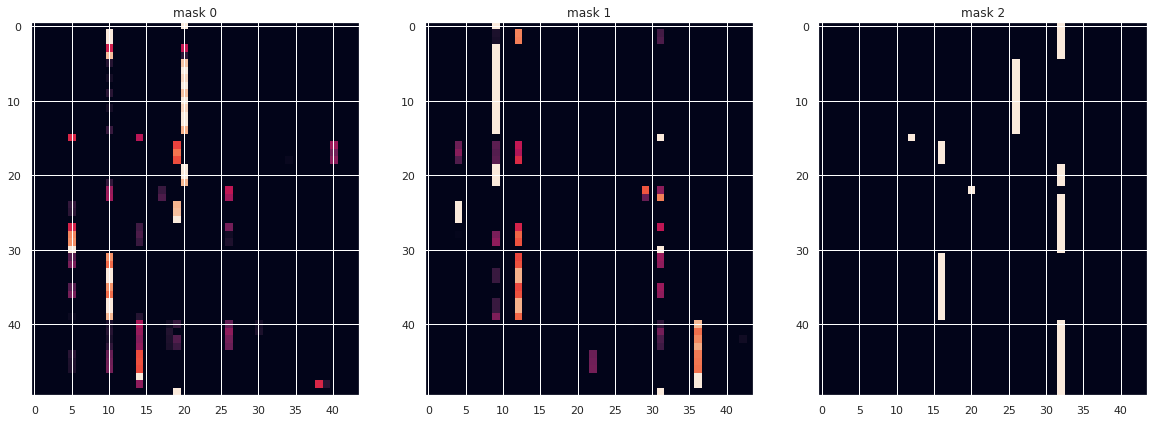

In [37]:
explain_matrix, masks = clf.explain(X_test)

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")